In [2]:
!pip install torchcfm numpy==1.26.4 anndata==0.10.3 scanpy==1.9.6 matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 13.1 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 98.1 MB/s eta 0:00:01
     |████████████████████████████████| 865 kB 80.9 MB/s eta 0:00:01
     |████████████████████████████████| 346 kB 107.3 MB/s eta 0:00:01
     |████████████████████████████████| 139 kB 106.3 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 104.3 MB/s ta 0:00:01
     |████████████████████████████████| 2.3 MB 48.3 MB/s eta 0:00:01
     |████████████████████████████████| 214 kB 123.6 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.2
    Uninstalling pandas-1.5.2:
      Successfully uninstalled pandas-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.4.0 requires pandas<1.6.0dev0,>=1.

In [3]:
import numpy
print(numpy.__version__)

1.26.4


In [4]:
import torch
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt

import sys
sys.path.append('/dss/dsshome1/0F/di93quv/OT-CFM/src/')

from ot_cfm.data_utils import load_adata, create_training_dataloader, create_dataloader
from ot_cfm.model import create_ot_cfm_model
from ot_cfm.training import train_cfm, save_ot_cfm_model, load_ot_cfm_model, create_ot_cfm_optimizer
from ot_cfm.transport import transport_pooled
from torchcfm.conditional_flow_matching import ExactOptimalTransportConditionalFlowMatcher

NOTE! Installing ujson may make loading annotations faster.


In [5]:
# When stuff not reloading properly...
import importlib
import ot_cfm
importlib.reload(ot_cfm)

<module 'ot_cfm' from '/dss/dsshome1/0F/di93quv/OT-CFM/src/ot_cfm/__init__.py'>

In [6]:
# Set up device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [7]:
# Load target2_moa dataset
target2_moa = load_adata("../data/mad_int_featselect_all_methods.h5ad")
target2_moa

AnnData object with n_obs × n_vars = 25329 × 1018
    obs: 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Batch', 'Metadata_PlateType', 'Metadata_PertType', 'Metadata_Row', 'Metadata_Column', 'Metadata_Microscope'
    obsm: 'combat', 'cpDistiller', 'cpDistiller_B', 'cpDistiller_S', 'cpDistiller_SBP', 'desc', 'fastMNN', 'gaushanvi', 'gaushvi', 'harmony', 'scanorama', 'scanorama_pca', 'scanvi', 'scpoli', 'scvi', 'seurat_cca', 'seurat_rpca', 'sphering', 'sysvi'

In [45]:
print(target2_moa.obs["Metadata_Source"].value_counts())

Metadata_Source
source_3     9599
source_6     8064
source_2     3828
source_10    2302
source_8     1536
Name: count, dtype: int64


In [6]:
# Get the head of the 591 features
target2_moa.var.head()

""
Cells_AreaShape_Compactness
Cells_AreaShape_Extent
Cells_AreaShape_Orientation
Cells_AreaShape_Perimeter
Cells_AreaShape_Solidity


In [7]:
import torch
torch.cuda.empty_cache()

In [10]:
sc.pp.pca(target2_moa)

In [6]:
target2_moa.write("../data/mad_int_featselect_all_methods_pca.h5ad")

In [8]:
target2_moa = sc.read_h5ad("../data/mad_int_featselect_all_methods_pca.h5ad")
target2_moa

AnnData object with n_obs × n_vars = 25329 × 1018
    obs: 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Batch', 'Metadata_PlateType', 'Metadata_PertType', 'Metadata_Row', 'Metadata_Column', 'Metadata_Microscope'
    uns: 'pca'
    obsm: 'X_pca', 'combat', 'cpDistiller', 'cpDistiller_B', 'cpDistiller_S', 'cpDistiller_SBP', 'desc', 'fastMNN', 'gaushanvi', 'gaushvi', 'harmony', 'scanorama', 'scanorama_pca', 'scanvi', 'scpoli', 'scvi', 'seurat_cca', 'seurat_rpca', 'sphering', 'sysvi'
    varm: 'PCs'

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


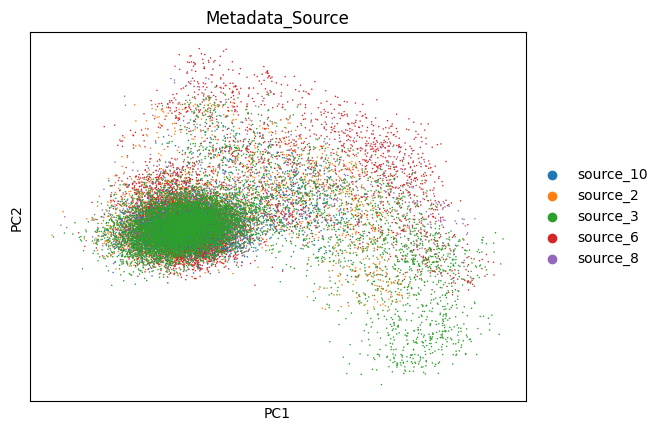

In [9]:
sc.pl.pca(target2_moa, color="Metadata_Source")

In [13]:
# Init model
ot_cfm_model = create_ot_cfm_model(adata=target2_moa, use_pca=False, time_varying=True).to(device)
ot_cfm_optimizer = create_ot_cfm_optimizer(ot_cfm_model)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=0.1)

In [14]:
ot_cfm_model

MLP(
  (layer1): Linear(in_features=1023, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=1, bias=True)
)

In [15]:
target2_moa.obs["Metadata_Source"].unique()

['source_2', 'source_6', 'source_8', 'source_10', 'source_3']
Categories (5, object): ['source_10', 'source_2', 'source_3', 'source_6', 'source_8']

### Model:

* OT-CFM model uses an MLP architecture whichh predicts a velocity field for the data transformation It combines input features, one-hot source labels, and (if time_varying=True) a time variable.
* If we set time_varying=True, we add a time dimension to the input.
The MLP thn learns a continuous transformation as a function of time. This enables smooth trajectories when simulating transformations ( via Neural ODE).
* If time_varying=False, then no time variable is added.
The model learns a direct mapping between the source and target distributions, without modeling intermediate states.

In [16]:
# Hyperparameters
epochs = 100  
batch_size = 64

In [17]:
dataset, dataloader = create_training_dataloader(
    target2_moa, batch_size=batch_size, exclude_source="source_2", use_pca=True
)

print(next(iter(dataloader))) 
batch = next(iter(dataloader))
print(batch["source"]["x"].shape)

{'source': {'x': tensor([[  1.8188,  -0.0704, -16.6236,  ...,   2.7132,  -2.1317,  -3.1920],
        [ -7.5494, -10.9549,  -5.2498,  ...,  -0.8584,   0.0880,   1.3694],
        [-11.8538,   1.3684,  -5.7366,  ...,  -0.8775,  -0.7270,  -0.6653],
        ...,
        [-14.1583,  -5.2355,  -2.0715,  ...,  -0.2965,   0.4069,  -0.2122],
        [ -1.8109,   4.4586,  12.3542,  ...,   0.5977,   0.5934,   0.6721],
        [ 16.1722,   2.9405,  11.6180,  ...,  -1.5321,   3.8407,   2.8221]])}, 'target': {'x': tensor([[ 6.6628e-01, -6.2536e+00, -9.8292e+00,  ...,  1.0252e+00,
         -4.3522e-02, -5.5217e-01],
        [-6.9002e+00, -4.3430e+00, -1.3838e+00,  ..., -7.7028e-02,
         -4.4552e-01,  1.5232e-01],
        [-8.3894e+00, -1.1714e+00, -1.7833e-02,  ..., -1.8089e+00,
          1.8129e+00, -2.3805e+00],
        ...,
        [ 1.6809e+01, -2.1274e+01,  2.7998e+00,  ...,  8.7199e-01,
          1.3550e+00,  1.4374e+00],
        [-4.7344e+00, -9.3780e+00, -2.3603e+00,  ..., -5.7674e-02,
   

In [18]:
print(next(iter(dataset))) 

{'source': {'x': tensor([[ -1.8616,   0.3551,   0.2037,  ...,  -0.9009,  -2.1470,   0.6305],
        [ -2.8329,   5.0008,   3.2249,  ...,   0.5472,   1.7124,   1.0466],
        [-12.2688,  -2.0018,  -1.2161,  ...,   0.0482,   0.6900,  -0.4695],
        ...,
        [  0.2918,   4.0419, -16.9987,  ...,   0.7802,  -0.4357,   0.3674],
        [-10.7274,   4.1901,  12.5388,  ...,  -3.5844,   0.6025,   1.7307],
        [  2.8440,  -5.2386,  15.3562,  ...,  -1.8324,  -0.9715,  -0.0798]])}, 'target': {'x': tensor([[-7.2296e+00, -3.2290e+00, -5.7170e+00,  ...,  1.9186e+00,
          1.9587e-01, -2.3569e-02],
        [-8.5829e+00, -5.0446e+00, -7.3882e+00,  ..., -4.6483e-02,
          1.1123e+00, -7.0160e-01],
        [-5.0700e+00, -7.5967e+00, -1.1532e+01,  ...,  7.8991e-02,
          2.6974e-01, -5.3550e-01],
        ...,
        [-1.2351e+01, -9.1335e+00, -8.8945e+00,  ...,  1.5232e+00,
          1.5747e+00,  1.6218e+00],
        [ 2.2602e+00, -2.0096e+00, -7.7121e-01,  ..., -1.3560e+00,
   

In [16]:
for batch in dataloader:
    print("Source Batch:", batch["source"]["x"].shape)
    #print("Source MOA:", batch["source"]["moa"])
    #print("Source Compound:", batch["source"]["cpd"])
    #print("Source Microscope:", batch["source"]["microscope"])
    print("Target Batch:", batch["target"]["x"].shape)
    #print("Target MOA:", batch["target"]["moa"])
    #print("Target Compound:", batch["target"]["cpd"])
    #print("Target Microscope:", batch["target"]["microscope"])
    print("Source Label Shape:", batch["source_label"].shape)
    break  

Source Batch: torch.Size([64, 50])
Target Batch: torch.Size([64, 50])
Source Label Shape: torch.Size([64, 4])


### Training
The NN learns transformation velocities between pooled source data and the target domain.

Key Steps:
1. Sample batches of source and target data
2. Concatenate data with one-hot source encoding and (if time varying is true) time
3. Predict transformations using the OT-CFM model and compute MSE loss with the target (source 2 here!)
4. Backprop and update the model weights

### time_varying = True

In [ ]:
trained_model2 = train_cfm(ot_cfm_model, ot_cfm_optimizer, FM, dataloader, device, epochs=epochs, plot_loss=True)

In [18]:
# save
save_ot_cfm_model(trained_model2, ot_cfm_optimizer, "../results/final_ot_cfm_pooled_time_var_true_10000.pt")

In [5]:
# Load the saved model and optimizer
checkpoint = torch.load("../results/final_ot_cfm_pooled_time_var_true_10000.pt")

# Extract model and optimizer
ot_cfm_model = checkpoint["model"]
ot_cfm_optimizer = checkpoint["optimizer"]

In [6]:
ot_cfm_model

TrainingTorchWrapper(
  (model): MLP(
    (layer1): Linear(in_features=55, out_features=64, bias=True)
    (layer2): Linear(in_features=64, out_features=64, bias=True)
    (layer3): Linear(in_features=64, out_features=1, bias=True)
  )
)

### Transport

1. Transports all sources to a target domain ( source_2)
2. Uses NeuralODE to simulate transformation trajectories
3. Output transformed data in as adata

Specifically, this function extracts all unique sources from adata.obs["Metadata_Source"] and sets one of them as the target source (here: "source_2"). All other sources are stored in source_list, which includes all sources except the target. A dataloader is created for each source, splitting its data into batches. Each source (excluding the target) is assigned a one-hot vector, where:
* The length of the vector is equal to the total number of sources.
* The position corresponding to the current source is set to 1, while others are 0.
This one-hot vector is used as an additional conditioning input for the model.

For each batch from each source the batch is passed through a NeuralODE model (ot_cfm_model), conditioned on its one-hot vector.
The model generates a trajectory over time and extracts the final transported state.
The transported features (x_transported) are stored along with the original source batch.
Metadata for both the original and transported data is stored in annot_combined.

In [12]:
target_source = "source_2"
batch_size = 64  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ot_cfm_model.eval() # we dont have dropout or batchnorm as this is ot-cfm but still good practise to set it!!

# Run the transport function
transported_adata = transport_pooled(
    adata=target2_moa, 
    ot_cfm_model=ot_cfm_model, 
    target_source=target_source, 
    batch_size=batch_size, 
    device=device, 
    save_adata_path="../results/final_transported_data.h5ad"  
)


transported_adata

Final transported data shape: (21501, 50)
Final annotation shape: (21501, 1)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 21501 × 50
    obs: 'Metadata_Source'
    obsm: 'X_pca'

In [9]:
# Load target2_moa dataset
transported_adata = load_adata("../results/final_transported_data.h5ad")
transported_adata

AnnData object with n_obs × n_vars = 21501 × 50
    obs: 'Metadata_Source'
    obsm: 'X_pca'

In [14]:
transported_adata.obs

,Metadata_Source
0,source_6_to_source_2
1,source_6_to_source_2
2,source_6_to_source_2
3,source_6_to_source_2
4,source_6_to_source_2
...,...
21496,source_3_to_source_2
21497,source_3_to_source_2
21498,source_3_to_source_2
21499,source_3_to_source_2


In [18]:
print("source_2" in transported_adata.obs["Metadata_Source"].unique())

False


In [19]:
# unique sources
transported_adata.obs["Metadata_Source"].value_counts()

# Does very transported source have a corresp target_source?
transported_adata.obs.groupby("Metadata_Source").count()

# Should hae "source_X_to_source_2"!!
transported_adata.obs["Metadata_Source"].unique()

/tmp/ipykernel_128971/2887801788.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  transported_adata.obs.groupby("Metadata_Source").count()


['source_6_to_source_2', 'source_8_to_source_2', 'source_10_to_source_2', 'source_3_to_source_2']
Categories (4, object): ['source_3_to_source_2', 'source_6_to_source_2', 'source_8_to_source_2', 'source_10_to_source_2']

In [21]:
print(transported_adata.obs["Metadata_Source"].value_counts())

Metadata_Source
source_3_to_source_2     9599
source_6_to_source_2     8064
source_2                 3828
source_10_to_source_2    2302
source_8_to_source_2     1536
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


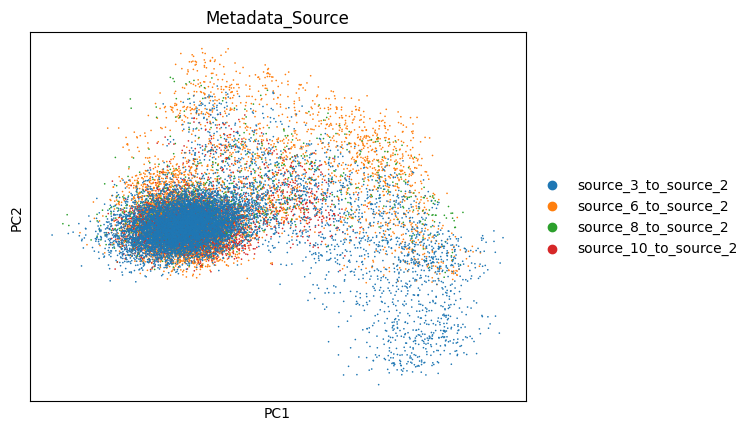

In [21]:
sc.pp.pca(transported_adata)
sc.pl.pca(transported_adata, color="Metadata_Source")

In [30]:
sc.pp.neighbors(transported_adata) 
sc.tl.umap(transported_adata)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


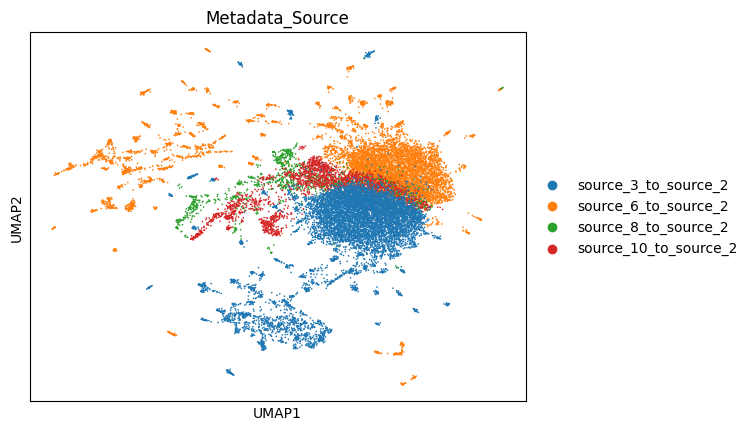

In [23]:
sc.pl.umap(transported_adata, color="Metadata_Source", save="final_umap_plot.png")

In [16]:
transported_adata.var_names

Index(['Cells_AreaShape_Compactness', 'Cells_AreaShape_Extent',
       'Cells_AreaShape_Orientation', 'Cells_AreaShape_Perimeter',
       'Cells_AreaShape_Solidity', 'Cells_AreaShape_Zernike_1_1',
       'Cells_AreaShape_Zernike_2_0', 'Cells_AreaShape_Zernike_2_2',
       'Cells_AreaShape_Zernike_3_1', 'Cells_AreaShape_Zernike_3_3',
       'Cells_AreaShape_Zernike_4_0', 'Cells_AreaShape_Zernike_4_2',
       'Cells_AreaShape_Zernike_4_4', 'Cells_AreaShape_Zernike_5_1',
       'Cells_AreaShape_Zernike_5_3', 'Cells_AreaShape_Zernike_5_5',
       'Cells_AreaShape_Zernike_6_0', 'Cells_AreaShape_Zernike_6_2',
       'Cells_AreaShape_Zernike_6_6', 'Cells_AreaShape_Zernike_7_1',
       'Cells_AreaShape_Zernike_7_3', 'Cells_AreaShape_Zernike_7_5',
       'Cells_AreaShape_Zernike_7_7', 'Cells_AreaShape_Zernike_8_0',
       'Cells_AreaShape_Zernike_8_2', 'Cells_AreaShape_Zernike_8_4',
       'Cells_AreaShape_Zernike_8_8', 'Cells_AreaShape_Zernike_9_1',
       'Cells_AreaShape_Zernike_9_3', 'Cells

In [10]:
# Add back source_2 for visualization
target_source_data = target2_moa[target2_moa.obs["Metadata_Source"] == "source_2"]
target_source_data.obs["Metadata_Source"] = "source_2"  # Keep naming consistent

# Concatenate transported data with source_2
target_source_data = target_source_data[:, transported_adata.var_names]  # Align features
transported_adata = sc.concat([transported_adata, target_source_data])

/tmp/ipykernel_1539419/1564784268.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  target_source_data.obs["Metadata_Source"] = "source_2"  # Keep naming consistent
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
#print(transported_adata.obs["Metadata_Source"].value_counts())
transported_adata

AnnData object with n_obs × n_vars = 25329 × 50
    obs: 'Metadata_Source'
    obsm: 'X_pca'

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


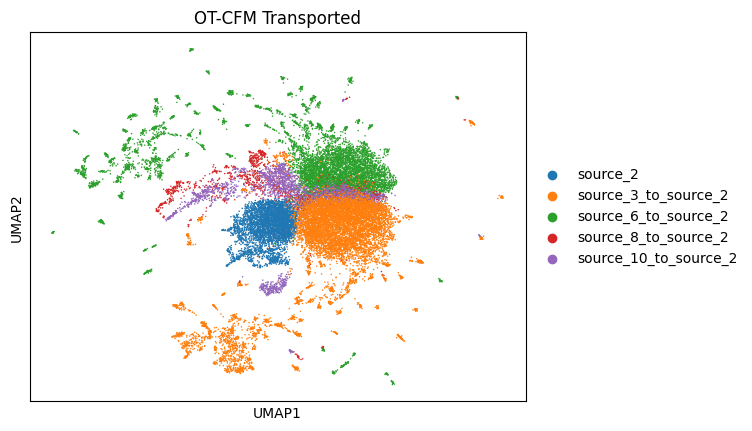

In [12]:
# Now plot UMAP
sc.pp.neighbors(transported_adata) 
sc.tl.umap(transported_adata)
sc.pl.umap(transported_adata, color="Metadata_Source", title="OT-CFM Transported")

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


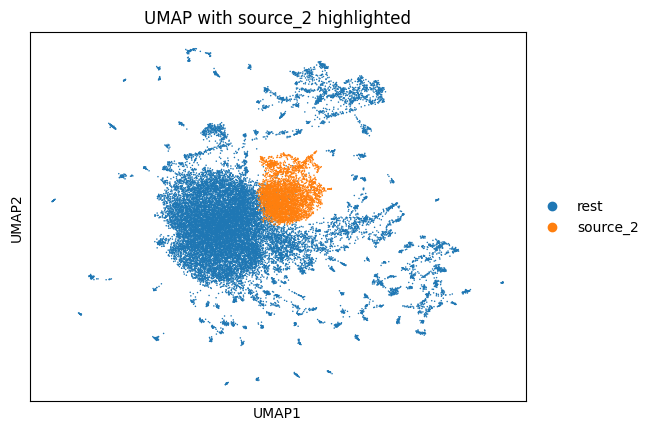

In [20]:
# Convert categorical column to string and replace values
transported_adata.obs["color_highlight"] = transported_adata.obs["Metadata_Source"].astype(str)
transported_adata.obs["color_highlight"] = transported_adata.obs["color_highlight"].replace({k: "rest" for k in transported_adata.obs["color_highlight"].unique() if k != "source_2"})

# Plot UMAP with modified colors
sc.pl.umap(transported_adata, color="color_highlight", title="UMAP with source_2 highlighted", save="final_umap_source_2.png")

In [13]:
# Save the PCA and UMAP results
transported_adata.write("../results/final_transformed_adata_with_embeddings.h5ad")

In [14]:
transported_adata.obsm['X_pca']

array([[-9.505047  , -3.9248111 ,  8.128077  , ..., -1.5345767 ,
        -2.2832382 ,  2.2110956 ],
       [-0.17377695, -3.8839476 , -7.4180384 , ..., -0.5797572 ,
        -0.17677736, -1.3417859 ],
       [-1.0760332 , -0.82010573, -5.8029685 , ...,  1.9028107 ,
         1.7271062 ,  1.3871374 ],
       ...,
       [-9.5034685 , -1.6041392 ,  7.8280487 , ..., -0.1655587 ,
        -1.0077145 ,  1.7018917 ],
       [ 1.7223284 , -3.49832   , -4.017707  , ...,  2.6817837 ,
         0.18960358, -0.58354384],
       [-0.48114806,  4.1477838 , 20.626003  , ..., -2.9555953 ,
        -1.2205162 , -2.9058444 ]], dtype=float32)

In [15]:
#Save in .uns o target2_moa original adata object
target2_moa.uns['ot_cfm_embeddings'] = transported_adata.obsm['X_pca']
ot_cfm_embeddings = target2_moa.uns['ot_cfm_embeddings']

In [16]:
# Inspect the embeddings in the 'uns' attrribute
print(target2_moa.uns.keys())  
print(target2_moa.uns['ot_cfm_embeddings'])  
print(target2_moa.uns['ot_cfm_embeddings'].shape)

dict_keys(['pca', 'ot_cfm_embeddings'])
[[-9.505047   -3.9248111   8.128077   ... -1.5345767  -2.2832382
   2.2110956 ]
 [-0.17377695 -3.8839476  -7.4180384  ... -0.5797572  -0.17677736
  -1.3417859 ]
 [-1.0760332  -0.82010573 -5.8029685  ...  1.9028107   1.7271062
   1.3871374 ]
 ...
 [-9.5034685  -1.6041392   7.8280487  ... -0.1655587  -1.0077145
   1.7018917 ]
 [ 1.7223284  -3.49832    -4.017707   ...  2.6817837   0.18960358
  -0.58354384]
 [-0.48114806  4.1477838  20.626003   ... -2.9555953  -1.2205162
  -2.9058444 ]]
(25329, 50)


In [17]:
target2_moa.write("../data/mad_int_featselect_all_methods_pca_with_otcfm_embeddings.h5ad")